# Let's import a bunch of stuff

In [2]:
import sys
import seaborn as sb
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import argparse
import gc

%matplotlib inline

In [3]:
adata = sc.read("CLUESImmvarMono.V4.1.h5ad", cache=True)
adata.shape

Only considering the two last: ['.1', '.h5ad'].
Only considering the two last: ['.1', '.h5ad'].


(221387, 1578)

# Let's first cluster with slightly lower resolution

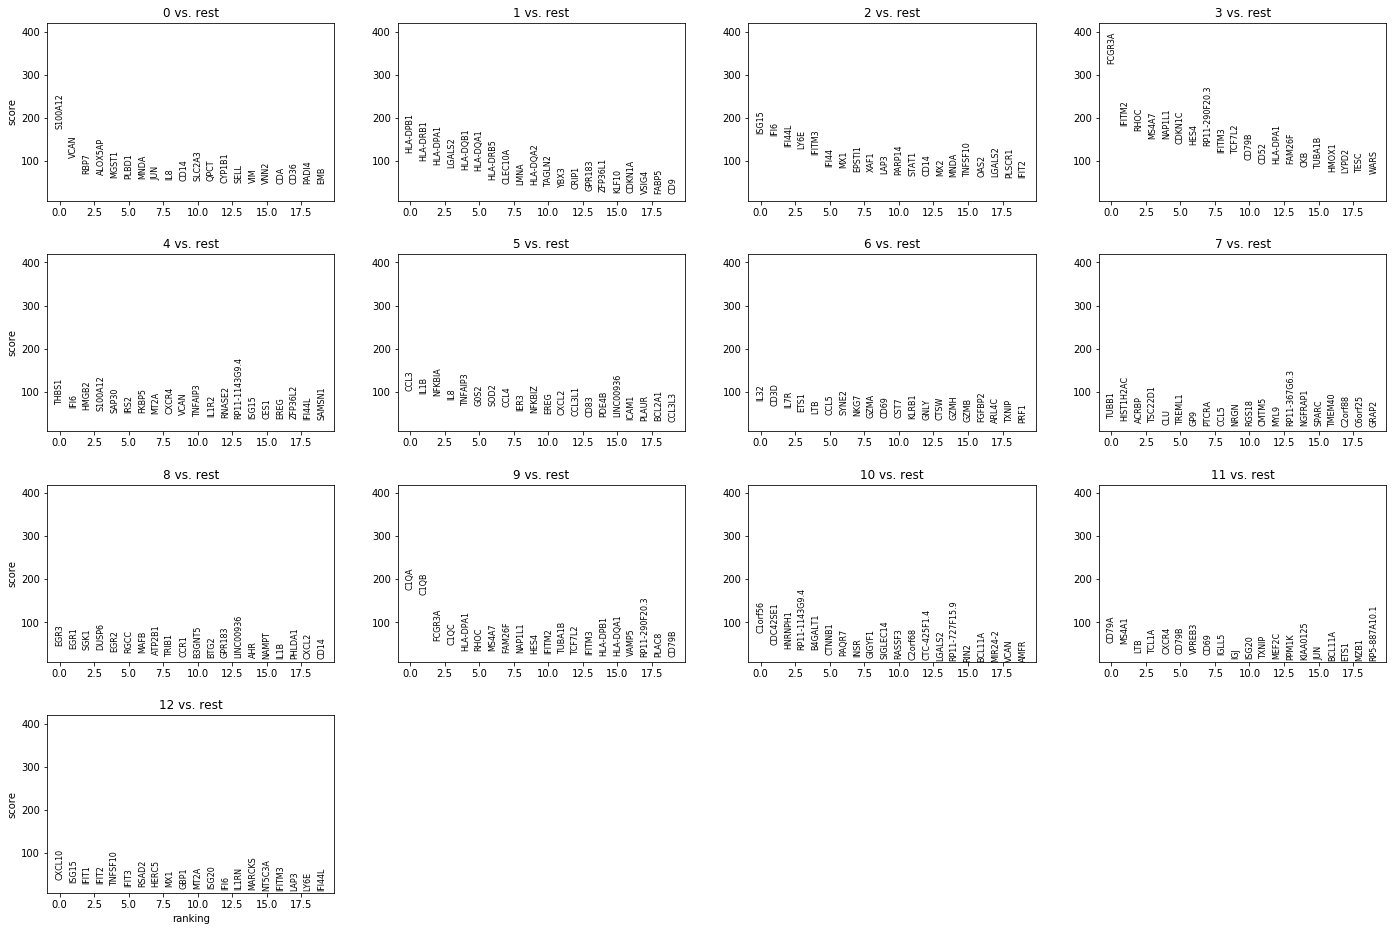

In [4]:
sc.tl.rank_genes_groups(adata, n_genes=20, groupby='louvain', use_raw=False)
sc.pl.rank_genes_groups(adata)

## Also plot some differentially expressed genes

## And of course UMAP with the louvain clusters highlighted

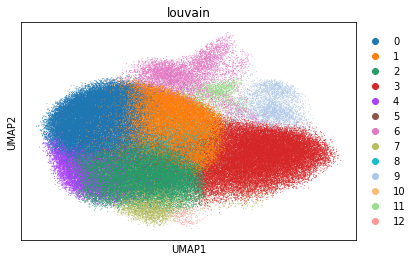

In [5]:
adata.uns['louvain_colors'] = sc.pl.palettes.vega_20_scanpy;
sc.pl.umap(adata, color='louvain', size=3)

In [ ]:
# #plot UMAP of cell types colored by clusters
# sc.tl.umap(adata)
# sc.pl.umap(adata, color='louvain', size=3)

In [ ]:
# adata2 = sc.read("/Users/yechun/Downloads/CLUESImmVar_processed.V3.h5ad")
# for i in range(0,13) :
#     print(i,end=":")
#     print(len(adata.obs.index[adata.obs.louvain==str(i)]& adata2.obs.index)/len(adata.obs.index[adata.obs.louvain==str(i)]))

In [6]:
# sc.pp.regress_out(adata, ['batch_cov'])

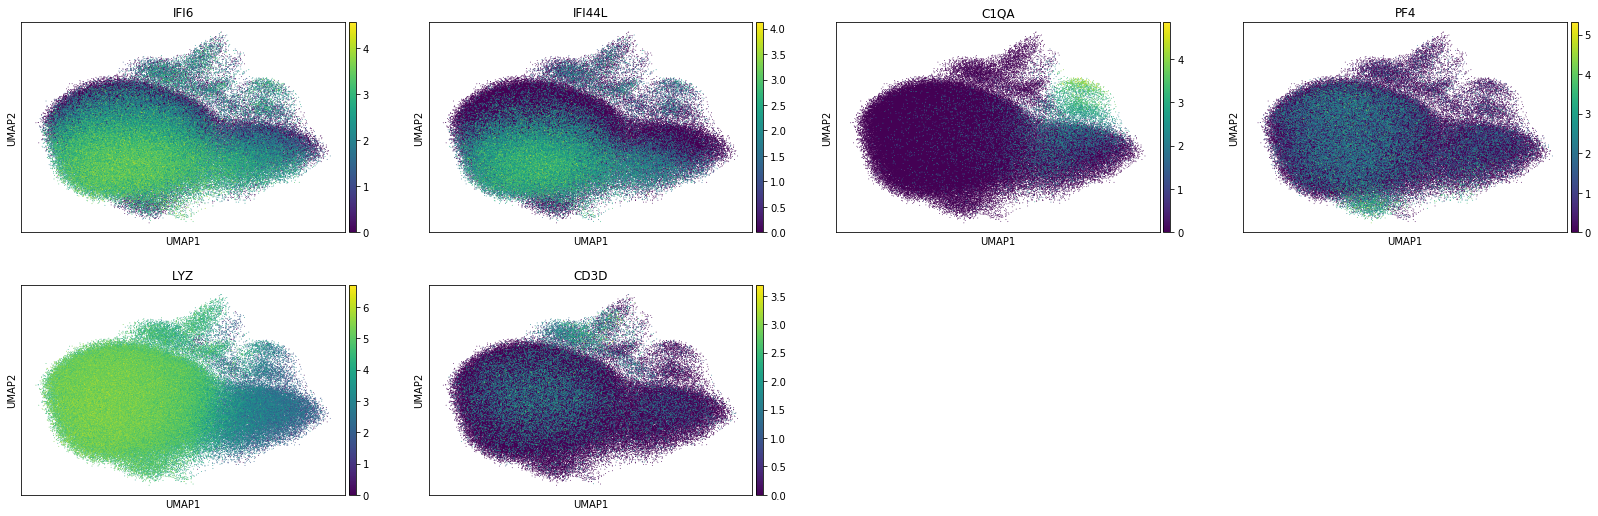

In [6]:
sc.pl.umap(adata, color=['IFI6','IFI44L','C1QA','PF4','LYZ','CD3D'], size=3)

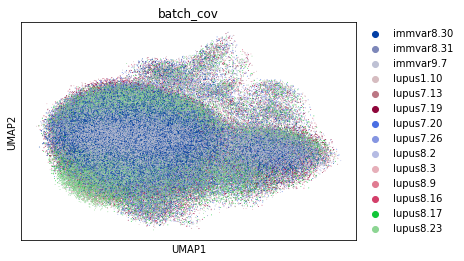

In [7]:
sc.pl.umap(adata, color=["batch_cov"], size=3)

# Now let's plot differences in cluster proportion

as a proportion of cell type
Cluster type:0
Beta=5.366260633125908, pvalue=0.013641133675405486
Cluster type:1
Beta=3.52020660746407, pvalue=0.04317590421140442
Cluster type:2
Beta=-10.497547764563269, pvalue=0.00011186790627558522
Cluster type:3
Beta=1.7144603082650702, pvalue=0.17160607249415794
Cluster type:4
Beta=-5.064614369892711, pvalue=0.011072399748478148
Cluster type:5
Beta=1.796763263295205, pvalue=0.10965102182508021
Cluster type:6
Beta=-0.10735626379270347, pvalue=0.5055863101361318
Cluster type:7
Beta=-1.2173865397026438, pvalue=1.5910714917313718e-19
Cluster type:8
Beta=4.363524503422649, pvalue=4.441172815398049e-10
Cluster type:9
Beta=-0.601094271060456, pvalue=0.00037733766103709577
Cluster type:10
Beta=0.45978870731383387, pvalue=0.004404185853300116
Cluster type:11
Beta=-0.09135616996369555, pvalue=0.14611689582269474
Cluster type:12
Beta=-0.0376083193564699, pvalue=0.30723287326770027


/Users/yimmieg/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<Figure size 1080x576 with 0 Axes>

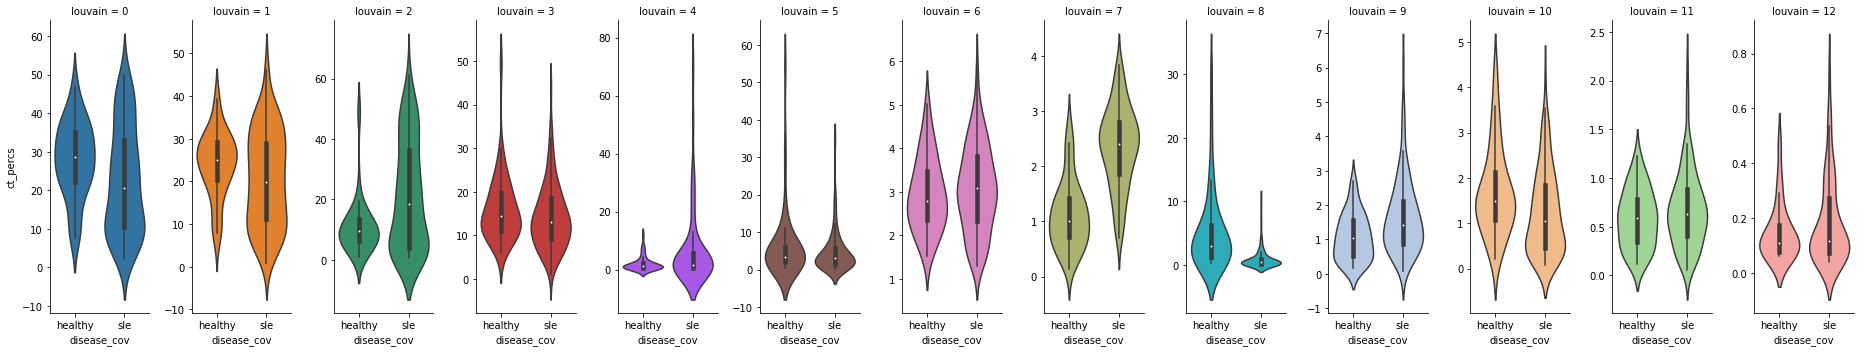

In [8]:
#get counts of cells for each cluster
ct_counts=adata.obs.groupby(['ind_cov', 'disease_cov','louvain'])['louvain'].count()
ct_percs = ct_counts/ct_counts.groupby(level=[0]).transform(sum)*100
ct_percs = ct_percs.reset_index(name='ct_percs')
ct_percs.ind_cov = ct_percs.ind_cov.apply(lambda x: x.split('_')[0])
ct_percs.ind_cov = ct_percs.ind_cov.astype("str")
ct_percs.reset_index(inplace=True)
ct_percs.louvain = ct_percs.louvain.astype("category")
ct_df=ct_percs.unstack(level=2, fill_value=0)

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))) :
    ct = ct_percs.louvain.cat.categories[ct_i]
    ct_perc = ct_percs.ct_percs[ct_percs.louvain==ct]
    disease = ct_percs.disease_cov[ct_percs.louvain==ct]
    disease = disease.astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    ##data = data.assign(ct_perc=ct_perc)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))

# #box plot as a proportion of cell type
# vars=[str(x) for x in list(range(n_cts))]
# ct_df['ind_cov']=ct_df.index.get_level_values('ind_cov').tolist()
# ct_df.index=ct_df['ind_cov']
# melted=pd.melt(ct_df, id_vars=['ind_cov', 'disease'], value_vars=vars)

#plot=sb.boxplot(x='disease', y='value', hue=ct_arg, data=melted).get_figure()
plt.figure(figsize=(15,8))
plot=sb.catplot(x='disease_cov', y='ct_percs', hue='louvain', data=ct_percs, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=False, palette=sc.pl.palettes.vega_20_scanpy)
#plt.subplots_adjust(wspace=0.03)

# Let's also plot the absolutely abundance of each cluster

In [9]:
## Let's grab the clinical and labs data and compare to our single cell estimates
clues_clinical = pd.read_table("v2.clinical.data.txt", index_col=False)
clues_clinical.genotypeid = clues_clinical.genotypeid.apply(lambda x: x.split('_')[0])
clues_clinical.subjectid = clues_clinical.subjectid.astype("str")
joined = ct_percs.join(clues_clinical.set_index('genotypeid'), on='ind_cov')

t1_labs = pd.read_table("T1labs.csv",sep=",")
t1_labs.SubjectID = t1_labs.SubjectID.astype("str")
joined = joined.join(t1_labs.set_index('SubjectID'), on='subjectid')

### test new code
joined.AbsBaso = joined.AbsBaso/1000
joined.AbsEosino = joined.AbsEosino/1000
joined.AbsLympho = joined.AbsLympho/1000
joined.AbsNeutro = joined.AbsNeutro/1000
joined.AbsMono = joined.AbsMono/1000

joined = joined.assign(pbmc = joined.WhiteBloodCell-joined.AbsNeutro-joined.AbsEosino-joined.AbsBaso)

joined[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']] = joined[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']].astype(str)

## now let's add in white blood cell counts for the immvar patients
immvar_pbmc = pd.read_table("immvar.pbmc.csv", index_col=False, sep=",")
immvar_pbmc.pbmc = immvar_pbmc.pbmc - (np.mean(immvar_pbmc.pbmc) - np.mean(joined.pbmc))

## this is not the most efficient code but will suffice for now
for i in list(range(12)) :
    igtb = immvar_pbmc.immvarid[i]
    joined.pbmc[joined.ind_cov==igtb] = immvar_pbmc.pbmc[i]

joined = joined.assign(estimate=joined.ct_percs/100*joined.pbmc)

joined[["ind_cov","disease_cov","louvain"]] = joined[["ind_cov","disease_cov","louvain"]].astype(str)
joined.plaquenilnow = joined.plaquenilnow.fillna(0)
joined.cellceptnow = joined.cellceptnow.fillna(0)
joined.steroralnow = joined.steroralnow.fillna(0)
joined.acrlymphopenia = joined.acrlymphopenia.fillna(0)

joined_pivot = joined.pivot_table(index=['ind_cov',"disease_cov","pbmc","plaquenilnow","cellceptnow","steroralnow","acrlymphopenia"], columns="louvain", values="estimate")
joined_pivot.reset_index(inplace=True)
joined_pivot = joined_pivot[joined_pivot.pbmc > 0]
joined_pivot.disease_cov = pd.Categorical(joined_pivot.disease_cov,categories=['healthy','sle'], ordered=True)


/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: read_table is deprecated, use read_csv instead.
/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


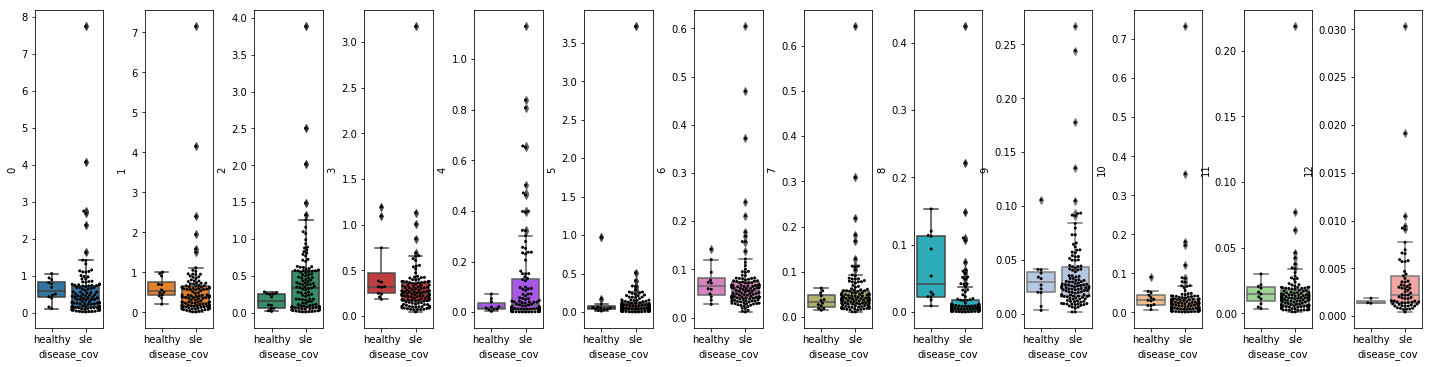

In [10]:
fig,ax = plt.subplots(nrows=1,ncols=len(adata.obs.louvain.cat.categories), figsize=(20,5))
fig.tight_layout()

for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    sb.boxplot(x="disease_cov", y=ct, data=joined_pivot, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    sb.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])

# Let's look at the IFN score now

In [11]:
ifn = pd.read_table("v2.ifn.sig.txt", sep=" ", index_col=False)
ifn.name = ifn.name.apply(lambda x: x.split('_')[0])
joined2 = ifn.join(joined.set_index("ind_cov"), on="name")
joined_pivot2 = joined2.pivot_table(index=['name',"disease_cov","pbmc","ifn","plaquenilnow","cellceptnow","steroralnow","acrlymphopenia"], columns="louvain", values="estimate")
joined_pivot2.reset_index(inplace=True)

/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


as a proportion of cell type
Cluster type:0
Beta=-0.061428480500851076, pvalue=9.815649633799322e-06
Cluster type:1
Beta=-0.047590270221359504, pvalue=0.00015117892149863035
Cluster type:2
Beta=0.0444322329175495, pvalue=3.705850075397483e-07
Cluster type:3
Beta=-0.008188991499584202, pvalue=0.18148604352040715
Cluster type:4
Beta=0.009731312121162778, pvalue=0.03651938624510489
Cluster type:5
Beta=-0.004955755212081848, pvalue=0.3841573589312438
Cluster type:6
Beta=-0.0017859126756062775, pvalue=0.1663678765391352
Cluster type:7
Beta=-0.0015854476162594621, pvalue=0.1555820167241464
Cluster type:8
Beta=-0.0015428175182857537, pvalue=0.10552317652631946
Cluster type:9
Beta=0.0001594687022254055, pvalue=0.8192139763207421
Cluster type:10
Beta=-0.0019920094154683324, pvalue=0.11601875632699488
Cluster type:11
Beta=-0.00023885007984339186, pvalue=0.5198989933050191
Cluster type:12
Beta=0.00012414735005229796, pvalue=0.28915640557049926


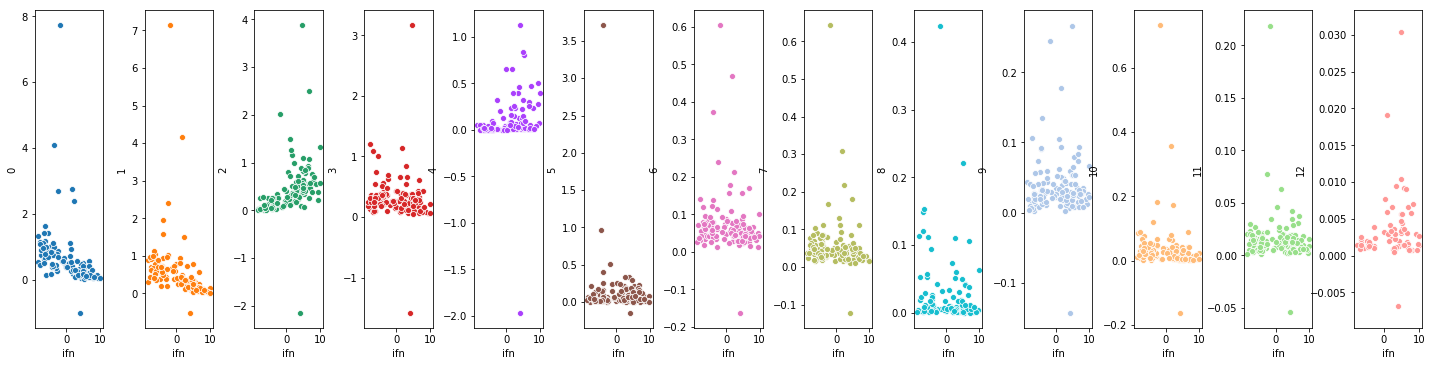

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=len(adata.obs.louvain.cat.categories), figsize=(20,5))
fig.tight_layout()

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    ct_perc = joined_pivot2[ct]
    ifn = joined_pivot2.ifn
    ifn = sm.add_constant(ifn)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), ifn.astype(float),missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))
    
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    sb.scatterplot(x="ifn", y=ct, data=joined_pivot2, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    ##sb.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])

## let's only look at disease

In [ ]:
joined_pivot2_sle = joined_pivot2[joined_pivot2.disease_cov == "sle"]

fig,ax = plt.subplots(nrows=1,ncols=len(adata.obs.louvain.cat.categories), figsize=(20,5))
fig.tight_layout()

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    ct_perc = joined_pivot2_sle[ct]
    ifn = joined_pivot2_sle.ifn
    ifn = sm.add_constant(ifn)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), ifn.astype(float),missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))
    
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    sb.scatterplot(x="ifn", y=ct, data=joined_pivot2_sle, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    ##sb.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])

## let's only look at healthy

In [ ]:
joined_pivot2_healthy = joined_pivot2[joined_pivot2.disease_cov == "healthy"]

fig,ax = plt.subplots(nrows=1,ncols=len(adata.obs.louvain.cat.categories), figsize=(20,5))
fig.tight_layout()

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    ct_perc = joined_pivot2_healthy[ct]
    ifn = joined_pivot2_healthy.ifn
    ifn = sm.add_constant(ifn)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), ifn.astype(float),missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))
    
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    sb.scatterplot(x="ifn", y=ct, data=joined_pivot2_healthy, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    ##sb.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])

# 6. Let's recompute the IFN score

In [ ]:
diffexp_annot = pd.read_table("ifn.analysis/diffexp.annotations.txt", sep="\t", index_col=False)
diffexp_annot.cluster = diffexp_annot.cluster.astype("category")

In [ ]:
for cluster_i in diffexp_annot.cluster.cat.categories:
    print(cluster_i)
    cluster_X = adata.X[:,adata.var_names.isin(diffexp_annot.gene[diffexp_annot.cluster==cluster_i])];
    adata.obs[cluster_i] = np.sum(cluster_X, axis=1)
    

In [ ]:
##fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5),sharex=True, sharey=True)
##fig.tight_layout()

sc.pl.umap(adata[adata.obs.disease_cov=="sle"], color=['all_ifn',"myeloid_ifn","cm_ifn"], palette="Greys", size=1) ##, vmin=min(adata.obs.all_ifn), vmax=max(adata.obs.all_ifn)*.75)
sc.pl.umap(adata[adata.obs.disease_cov=="healthy"], color=['all_ifn',"myeloid_ifn","cm_ifn"], palette="Greys", size=1) ##,vmin=min(adata.obs.all_ifn), vmax=max(adata.obs.all_ifn)*.75)



##sc.pl.umap(adata[adata.obs.disease_cov=="healthy",], color = "all_ifn", ax=ax[1])                                                      

In [ ]:

sc.pl.umap(adata[adata.obs.disease_cov=="sle"], color=['CD14',"FCGR3A","G0S2"], palette="Greys", size=1) ##, vmin=min(adata.obs.all_ifn), vmax=max(adata.obs.all_ifn)*.75)
sc.pl.umap(adata[adata.obs.disease_cov=="healthy"], color=['CD14',"FCGR3A","G0S2"], palette="Greys", size=1) ##,vmin=min(adata.obs.all_ifn), vmax=max(adata.obs.all_ifn)*.75)



In [ ]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','louvain'])['all_ifn'].mean()
plot_df = plot_df.reset_index(name='all_ifn_sum')

sb.catplot(x="disease_cov", y="all_ifn_sum", hue='louvain', data=plot_df, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=True)

##n_cts=ct_df.shape[1]-1
for cluster_i in list(range(0,8)):
    cluster = plot_df.louvain.cat.categories[cluster_i]
    all_ifn_sum = plot_df.all_ifn_sum[plot_df.louvain == cluster]
    disease = plot_df.disease_cov[plot_df.louvain==cluster].astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.OLS(all_ifn_sum.astype(float), disease.astype(float), missing='drop')
    ##est=sm.OLS("all_ifn~disease_cov", data=adata.obs.input,missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Cluster='+str(cluster)+',Beta='+str(effect)+', pvalue='+str(pval))

In [ ]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','louvain'])['cm_ifn'].mean()
plot_df = plot_df.reset_index(name='cm_ifn_sum')

sb.catplot(x="disease_cov", y="cm_ifn_sum", hue='louvain', data=plot_df, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=True)

##n_cts=ct_df.shape[1]-1
for cluster_i in list(range(0,8)):
    cluster = plot_df.louvain.cat.categories[cluster_i]
    cm_ifn_sum = plot_df.cm_ifn_sum[plot_df.louvain == cluster]
    disease = plot_df.disease_cov[plot_df.louvain==cluster].astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.OLS(cm_ifn_sum.astype(float), disease.astype(float), missing='drop')
    ##est=sm.OLS("cm_ifn~disease_cov", data=adata.obs.input,missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Cluster='+str(cluster)+',Beta='+str(effect)+', pvalue='+str(pval))

In [ ]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','louvain'])['myeloid_ifn'].mean()
plot_df = plot_df.reset_index(name='myeloid_ifn_sum')

sb.catplot(x="disease_cov", y="myeloid_ifn_sum", hue='louvain', data=plot_df, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=True)

##n_cts=ct_df.shape[1]-1
for cluster_i in list(range(0,8)):
    cluster = plot_df.louvain.cat.categories[cluster_i]
    myeloid_ifn_sum = plot_df.myeloid_ifn_sum[plot_df.louvain == cluster]
    disease = plot_df.disease_cov[plot_df.louvain==cluster].astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.OLS(myeloid_ifn_sum.astype(float), disease.astype(float), missing='drop')
    ##est=sm.OLS("myeloid_ifn~disease_cov", data=adata.obs.input,missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Cluster='+str(cluster)+',Beta='+str(effect)+', pvalue='+str(pval))

In [ ]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','louvain'])['th_specific'].mean()
plot_df = plot_df.reset_index(name='th_specific_sum')

sb.catplot(x="disease_cov", y="th_specific_sum", hue='louvain', data=plot_df, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=True)

##n_cts=ct_df.shape[1]-1
for cluster_i in list(range(0,8)):
    cluster = plot_df.louvain.cat.categories[cluster_i]
    th_specific_sum = plot_df.th_specific_sum[plot_df.louvain == cluster]
    disease = plot_df.disease_cov[plot_df.louvain==cluster].astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.OLS(th_specific_sum.astype(float), disease.astype(float), missing='drop')
    ##est=sm.OLS("myeloid_ifn~disease_cov", data=adata.obs.input,missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Cluster='+str(cluster)+',Beta='+str(effect)+', pvalue='+str(pval))